# Analise descritiva


[ml map sklearn](https://scikit-learn.org/stable/tutorial/machine_learning_map/)

## Carregar dados tratados

In [113]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [165]:
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, f_classif, f_regression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score

import joblib

In [115]:
def carregar_joblib():
    df = joblib.load("../out/tratamento_target_col_calc.joblib")
    return df

In [116]:
def print_histograma_comprar_vender(df):
    df['decisao'].value_counts(normalize=True).map("{:.1%}".format)
    fig = px.histogram(df, x="decisao", color="decisao")
    fig.show()

In [137]:
def print_correlacoes(df):

    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(df.corr(), cmap="Wistia", annot=True, fmt = '.2f', ax=ax)
    plt.show()

In [168]:
def remover_variaveis_ja_explicadas(df, best_features):
    to_remove = set(best_features) ^ set(df.columns)
    to_remove.remove('decisao')
    print("Colunas a remover do df original: ", to_remove)
    df = df.drop(to_remove, axis=1)
    # df = df.drop(['resultado_bruto'], axis=1)

    return df

## P value

In [119]:
def print_p_value(df):
    all_col = " + ".join(df.drop("decisao", axis=1).columns)
    model = smf.glm(formula="decisao ~ " + all_col, data=df,
                    family = sm.families.Binomial()).fit()

    print(model.summary()) 

## Feature selection

In [150]:
def print_feature_selection_extra_trees(df):
    modelo = ExtraTreesClassifier(random_state=1)
    x = df.drop("decisao", axis=1)
    y = df["decisao"]
    modelo.fit(x, y)

    caracteristicas_importantes = pd.DataFrame(modelo.feature_importances_, x.columns).sort_values(by=0, ascending=False)
    print(caracteristicas_importantes)
    return caracteristicas_importantes

In [166]:
def print_feat_sel_select_k_best(df):
    X = df.drop("decisao", axis=1)
    y = df["decisao"]

    select_percentile = SelectPercentile(score_func=f_regression, percentile=30)

    select = SelectKBest(score_func=f_classif, k=5)

    X_new = select_percentile.fit_transform(X, y)
    print(X_new.shape)
    
    select.fit(X, y)

    filter = select.get_support()
    
    print("Selected best 5:")
    print(X.columns[filter])
    return list(X.columns[filter])


In [122]:
def ajustar_scaler(tabela_original):
    scaler = StandardScaler()
    tabela_auxiliar = tabela_original.drop("decisao", axis=1)
    
    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar), tabela_auxiliar.index, tabela_auxiliar.columns)
    tabela_auxiliar["decisao"] = tabela_original["decisao"]
    
    return tabela_auxiliar


In [123]:
def salvar_df_in_joblib(df, file_name: str = "../out/result_analise_desc.joblib"):

    joblib.dump(df, file_name)

    print("arquivo joblib de df analise descritiva criado com sucesso")


# Execucao

Feature Selection
(1852, 21)
Index(['ativo_total', 'ativo_circ', 'caixa_equiv_caixa', 'outros_ativos_circ',
       'ativo_permanente', 'outros_ativos_nao_circ', 'imobilizado',
       'intangivel', 'passivo_total', 'passivo_circ', 'passivo_nao_circ',
       'patrimonio_liq', 'capital_social', 'receita_liq',
       'custo_bens_servicos', 'resultado_bruto', 'despesas_gerais',
       'financeiras', 'resultado_antes_trib', 'lucro_op', 'decisao'],
      dtype='object')


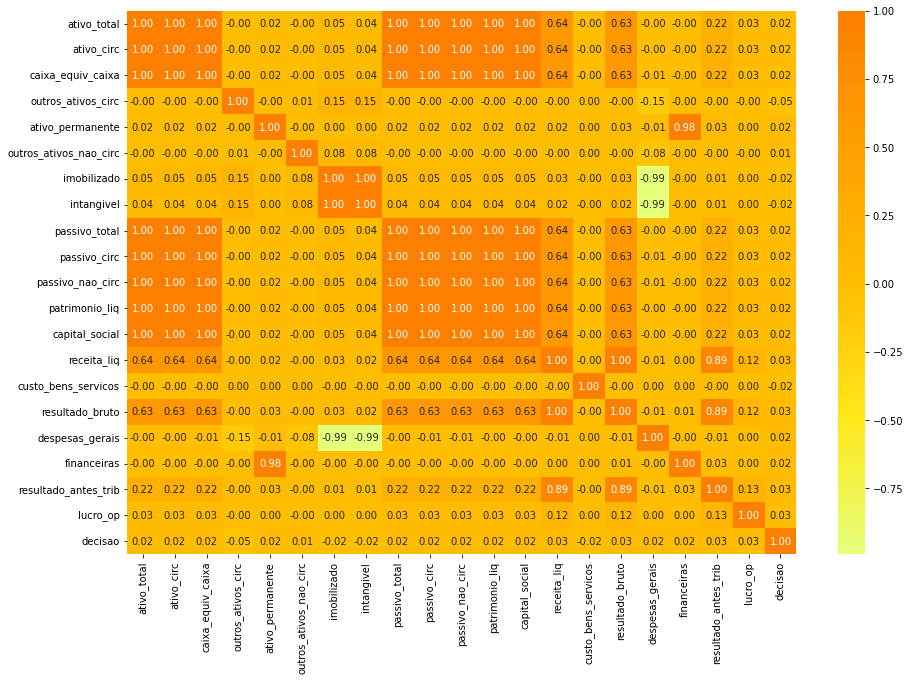

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning:

overflow encountered in exp

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1014: RuntimeWarning:

divide by zero encountered in log

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1014: RuntimeWarning:

invalid value encountered in multiply



                 Generalized Linear Model Regression Results                  
Dep. Variable:                decisao   No. Observations:                 1852
Model:                            GLM   Df Residuals:                     1832
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 24 Oct 2021   Deviance:                       2521.3
Time:                        22:14:39   Pearson chi2:                 1.85e+03
No. Iterations:                    20   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -48

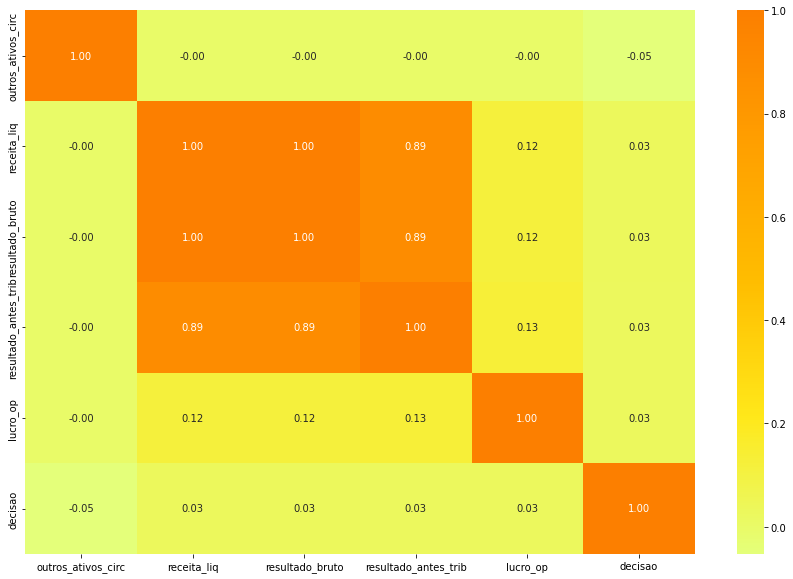

                      outros_ativos_circ  receita_liq  resultado_bruto  \
outros_ativos_circ              1.000000    -0.001780        -0.001747   
receita_liq                    -0.001780     1.000000         0.999942   
resultado_bruto                -0.001747     0.999942         1.000000   
resultado_antes_trib           -0.001483     0.891076         0.893803   
lucro_op                       -0.001492     0.117079         0.117434   
decisao                        -0.052815     0.032715         0.032901   

                      resultado_antes_trib  lucro_op   decisao  
outros_ativos_circ               -0.001483 -0.001492 -0.052815  
receita_liq                       0.891076  0.117079  0.032715  
resultado_bruto                   0.893803  0.117434  0.032901  
resultado_antes_trib              1.000000  0.130585  0.028342  
lucro_op                          0.130585  1.000000  0.026957  
decisao                           0.028342  0.026957  1.000000  
arquivo joblib de df anali

In [169]:
def main():
    print("Feature Selection")

    df = carregar_joblib()

    print(df.shape)
    print(df.columns)

    df = ajustar_scaler(df)

    # print_histograma_comprar_vender(df)

    print_correlacoes(df)
    print_p_value(df)


    print_feature_selection_extra_trees(df)

    best_features = print_feat_sel_select_k_best(df)
    
    df = remover_variaveis_ja_explicadas(df, best_features)
    print("Correlacoes apos remover algumas colunas")

    # print_correlacoes(df)


    # print("#-" * 40)

    print_p_value(df)

    # # print(df.shape)


    print_correlacoes(df)
    # salvar_df_in_joblib(df, "../out/result_analise_desc.joblib")

    print(df.corr())


    # print_correlacoes(df)

    salvar_df_in_joblib(df, "../out/result_analise_desc_scaled.joblib")

    return df

    
df = main()
